# 基于量子门控循环神经网络（QGRNN）预测股票价格
参考文献：https://ieeexplore.ieee.org/abstract/document/10806779

经典循环神经面临着梯度消失和梯度爆炸的问题，限制了其对数据中长期相关性的学习。为解决这一问题，文章提出了一种门控循环神经网络 Quantum Gated Recurrent Neural Networks (QGRNN)，其将门控机制集成到了量子神经网络的框架中。作者证明了 QGRNN 可以保留长期相关的梯度信息，且能够有效防止梯度消失和爆炸的问题，同时由于合理的线路构造，可以避免 QNN 中可能出现的贫瘠高原现象。文章中提出了两种具体构造，QLSTM 和 QGRU， 由于后者所消耗的资源更少，本文档以 QGRU 预测股票价格的任务为例，展示其优异的性能。而 QLSTM 的构造类似，只需将代码稍加改变，即可实现，关于更多的信息请参考原文及其补充材料。

我们先构造数据集。

In [2]:
from mindquantum import *
import mindspore as ms
import numpy as np
from mindspore.dataset import NumpySlicesDataset
from mindspore import nn, Model
from mindspore.train.callback import LossMonitor
import matplotlib.pyplot as plt

ms.set_seed(1)
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

def get_dataset(file_name:str='BA', x_length:int=5, rate:float=0.8, batch_size:int=4):
    "获取股票数据并构建数据集 除了正常的训练集和测试集之外，还将训练集中的后 20% 构造为单独的数据集，用于确定模型结果的缩放因子。"

    # 读取数值数据, 第 4 行为 Close 收盘价
    data = np.loadtxt(f'./src/{file_name}.csv', delimiter=',', skiprows=1, usecols=[4])

    # 数据缩放到 -1 到 1 之间，后续作为编码时单量子比特的旋转角度
    min_val = min(data)
    max_val = max(data)
    scaled_data = [2 * ((x - min_val) / (max_val - min_val)) - 1 for x in data]
    
    # 拆分
    x, y = [], []
    size = len(data)
    for i in range(size - x_length):
        x.append(scaled_data[i:i + x_length])
        y.append(scaled_data[i + x_length])
    
    point0 = int(0.8*rate*size) # 将训练集中的后 20% 用于确定缩放因子
    point1 = int(rate*size)
    train_dataset = NumpySlicesDataset((x[:point1], y[:point1]), column_names=["x", "y"]).batch(batch_size)
    scale_dataset = NumpySlicesDataset((x[point0:point1], y[point0:point1]), column_names=["x", "y"]).batch(8)
    test_dataset = NumpySlicesDataset((x[point1:], y[point1:]), column_names=["x", "y"]).batch(8)
    return train_dataset, scale_dataset, test_dataset

file_name = 'BA'
x_length = 4 # 序列长度
rate = 0.8
batch_size = 4
train_dataset, scale_dataset, test_dataset = get_dataset(file_name, x_length, rate, batch_size)

[WARNING] ME(24568:18404,MainProcess):2025-05-23-15:05:38.395.897 [mindspore\context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.



QGRU 的整体结构如下图所示，其中 $\rho_{h_{t}}$ 表示 $t$ 时刻 QGRU 的隐藏状态，模块 $U_{in}(x_t)$ 表示 $t$ 时刻的编码模块，模块 $PQC_i$ 为一段参数化拟设线路。作者为了便于实现，拟设线路采用了硬件高效线路。

![qgru](./src/qgru.png)

我们先设计 $PQC_i$ 模块的构造函数。

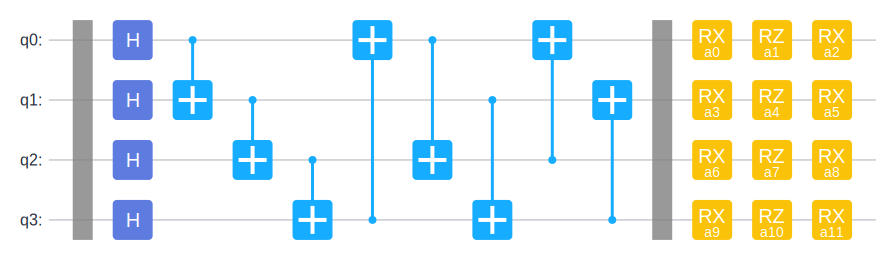

In [3]:
def get_pqc_circ(n_qubits:int, name:str): 
    "返回 QGRU 模块中的一个 PQC 模块。"
    circ = Circuit()
    circ += BarrierGate(False).on(range(n_qubits))
    circ += UN(H, n_qubits)
    for i in range(n_qubits-1):
        circ += X.on(i+1, i)
    circ += X.on(0, i+1) # type:ignore

    if n_qubits == 2:
        circ.x(1,0)
        circ.x(0,1)
    else:
        qubits = list(range(n_qubits)) * 2
        for i in range(n_qubits):
            circ.x(qubits[i+2], qubits[i])
    circ += BarrierGate(False).on(range(n_qubits))

    theta = PRGenerator(name)
    for i in range(n_qubits):
        circ.rx(theta.new(), i)
        circ.rz(theta.new(), i)
        circ.rx(theta.new(), i)
    return circ

pqc_4 = get_pqc_circ(4, 'a') # 4 量子比特的 PQC 模块
pqc_4.svg()

由于到相邻时刻之间，QGRU 的比特之间有交叉，我们构造一个函数来生成不同时刻 QGRU 所作用的量子比特。注意到对于长度为 x_length 的序列，共需要 4 + 3 * x_length 个量子比特，我们先将起始时刻编码隐藏状态的 4 个比特定义为 $q_0\sim q_3$, 而将其余比特作为 “辅助比特” 不断添加进来。

In [4]:
def get_apply_qubits(x_length:int):
    "返回每次施加量子线路时所作用的量子比特, x_length 应小于 7 不然后续模拟器跑不动了。"
    qubits = []
    aux_qubits = list(range(4, 4 + 3 * x_length))
    j = 3 # aux 计数
    qubits = [[0, 4, 1, 5, 2, 3, 6]]

    for i in range(x_length - 1):
        tem = [qubits[-1][0], aux_qubits[j], qubits[-1][1], aux_qubits[j+1], qubits[-1][2], qubits[-1][5], aux_qubits[j+2]]
        qubits.append(tem)
        j += 3
    return qubits

qubits = get_apply_qubits(5)
print(qubits)

[[0, 4, 1, 5, 2, 3, 6], [0, 7, 4, 8, 1, 3, 9], [0, 10, 7, 11, 4, 3, 12], [0, 13, 10, 14, 7, 3, 15], [0, 16, 13, 17, 10, 3, 18]]


可见，$t=0$ 时刻，QGRU 模块作用到 [0, 4, 1, 5, 2, 3, 6] 比特上，$t=1$ 时刻 QGRU 模块作用到 [0, 7, 4, 8, 1, 3, 9] 比特上，以此类推。

接下来构造 QGRU 模块，其中编码模块 $U_{in}(x_t)$ 我们采用旋转角度编码。

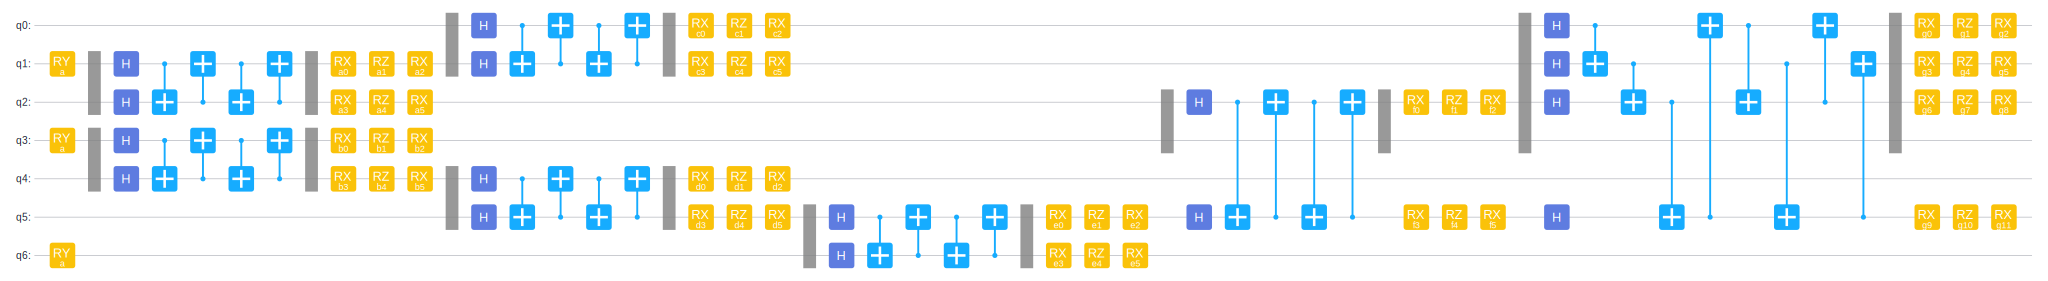

In [5]:
def get_gru_circ(qubits:list[int], encoder_name:str):
    "返回一个 QGRU 单元的量子线路"
    circ = Circuit()

    # 旋转角度编码
    circ.ry(encoder_name, qubits[1])
    circ.ry(encoder_name, qubits[3])
    circ.ry(encoder_name, qubits[6])
    circ.as_encoder()
    
    # 各 PQC 模块
    circ += apply(get_pqc_circ(2, 'a'), [qubits[1], qubits[2]])
    circ += apply(get_pqc_circ(2, 'b'), [qubits[3], qubits[4]])
    circ += apply(get_pqc_circ(2, 'c'), [qubits[0], qubits[1]])
    circ += apply(get_pqc_circ(2, 'd'), [qubits[4], qubits[5]])
    circ += apply(get_pqc_circ(2, 'e'), [qubits[5], qubits[6]])
    circ += apply(get_pqc_circ(2, 'f'), [qubits[2], qubits[5]])
    circ += apply(get_pqc_circ(4, 'g'), [qubits[0], qubits[1], qubits[2], qubits[5]])
    return circ

gru_circ = get_gru_circ(list(range(7)), 'a')
gru_circ.svg()

QGRNN 整体量子线路的规模取决于 x_length 的大小。

In [6]:
def get_circ(x_length:int):
    "获取基于 QGRU 的 QGRNN 整体线路图"
    qubits = get_apply_qubits(x_length)

    circ = Circuit()
    for i in range(x_length):
        circ += get_gru_circ(qubits[i], f"data_{i}")
    return circ

for length in range(2, 6):
    circ = get_circ(length)
    print(f'x_length = {length}', '线路比特数：', circ.n_qubits, ' 线路双门深度：', circ.depth(False))

x_length = 2 线路比特数： 10  线路双门深度： 42
x_length = 3 线路比特数： 13  线路双门深度： 63
x_length = 4 线路比特数： 16  线路双门深度： 84
x_length = 5 线路比特数： 19  线路双门深度： 105


接下来，我们装配并训练模型，包括线路、模拟器、哈密顿量、网络层、优化器、损失函数。本文使用 $q_3$ 的期望值作为预测依据，故而将哈密顿量设为了 $Z_3$。


In [7]:
def get_model(x_length):
    "装配模型"
    circ = get_circ(x_length)
    sim = Simulator('mqvector', circ.n_qubits)
    ham = Hamiltonian(QubitOperator('Z3'))

    sim = Simulator('mqvector', circ.n_qubits)
    grad_ops = sim.get_expectation_with_grad(ham, circ)

    circ.ansatz_params_name
    qnet = MQLayer(grad_ops)
    optimizer = nn.Adam(params=qnet.trainable_params(), learning_rate=0.1)
    model = Model(qnet, nn.MSELoss(), optimizer, metrics={"mse"})
    return model

x_length = 4
epoch = 1
model = get_model(x_length)
model.train(epoch, train_dataset, callbacks=[LossMonitor(50)])


epoch: 1 step: 50, loss is 0.15613135695457458
epoch: 1 step: 100, loss is 0.10429250448942184
epoch: 1 step: 150, loss is 0.1573553830385208
epoch: 1 step: 200, loss is 0.14571119844913483
epoch: 1 step: 250, loss is 0.18019801378250122


在实现过程中，我们发现模型在预测时，会有一个神秘的缩放因子存在, 我们使用模型在一个训练集的一个子集（此处被命名为 scale_dataset）上预测值和真实值之间的关系来确定确定该因子。为避免部分反常值点对结果的影响，我们设计一个函数去除 20% 的最大和最小值。

In [8]:
def remove_outliers(list1, list2, threshold=0.2):
    """去除列表1中偏离中心的异常点及对应列表2的点"""
    # 转换为numpy数组以便计算
    arr1 = np.array(list1)
    arr2 = np.array(list2)
    
    # 计算列表1的中心值(中位数)和绝对偏差
    median = np.median(arr1)
    deviations = np.abs(arr1 - median)
    
    # 计算阈值(使用0.6745 * MAD作为标准差估计，对应正态分布)
    # 这里我们调整阈值以去除约20%的异常点
    threshold_value = np.percentile(deviations, 100*(1-threshold))
    
    # 创建掩码，True表示保留的点
    mask = deviations <= threshold_value
    
    # 应用掩码过滤两个数组
    filtered_arr1 = arr1[mask]
    filtered_arr2 = arr2[mask]
    return filtered_arr1.tolist(), filtered_arr2.tolist()


def find_scale_factor(model, scale_dataset):
    "模型在预测时, 结果中会有一个神秘的缩放因子存在, 本函数用于确定该因子"
    x_list = []
    predictions, y_list = [], []
    
    for xs, ys in scale_dataset:
        for x, y in zip(xs, ys):
            x_list.append(x)
            y_list.append(y.asnumpy().flatten())

    for x in x_list:
        predictions.append(model.predict(ms.tensor([x])).asnumpy().flatten())

    y_list, predictions = remove_outliers(y_list, predictions, 0.2) # 删除异常点
    scale = np.mean(y_list) / np.mean(predictions)
    return scale

scale = find_scale_factor(model, scale_dataset) 
print('缩放因子为：', scale) # 打印缩放因子

缩放因子为： 7.684397934452219


在利用模型进行预测时，需要将模型的输出结果乘上这个缩放因子，才是最终的预测值。

In [9]:
def predict(model, scale, x):
    "乘上缩放因子才是最终的预测结果"
    prediction = scale * model.predict(ms.tensor([x])).asnumpy().flatten()
    return prediction

构造测试函数，观察该缩放因子在 scale_dateset 上的预测效果，计算损失函数。

损失函数为： 0.001388403301191802


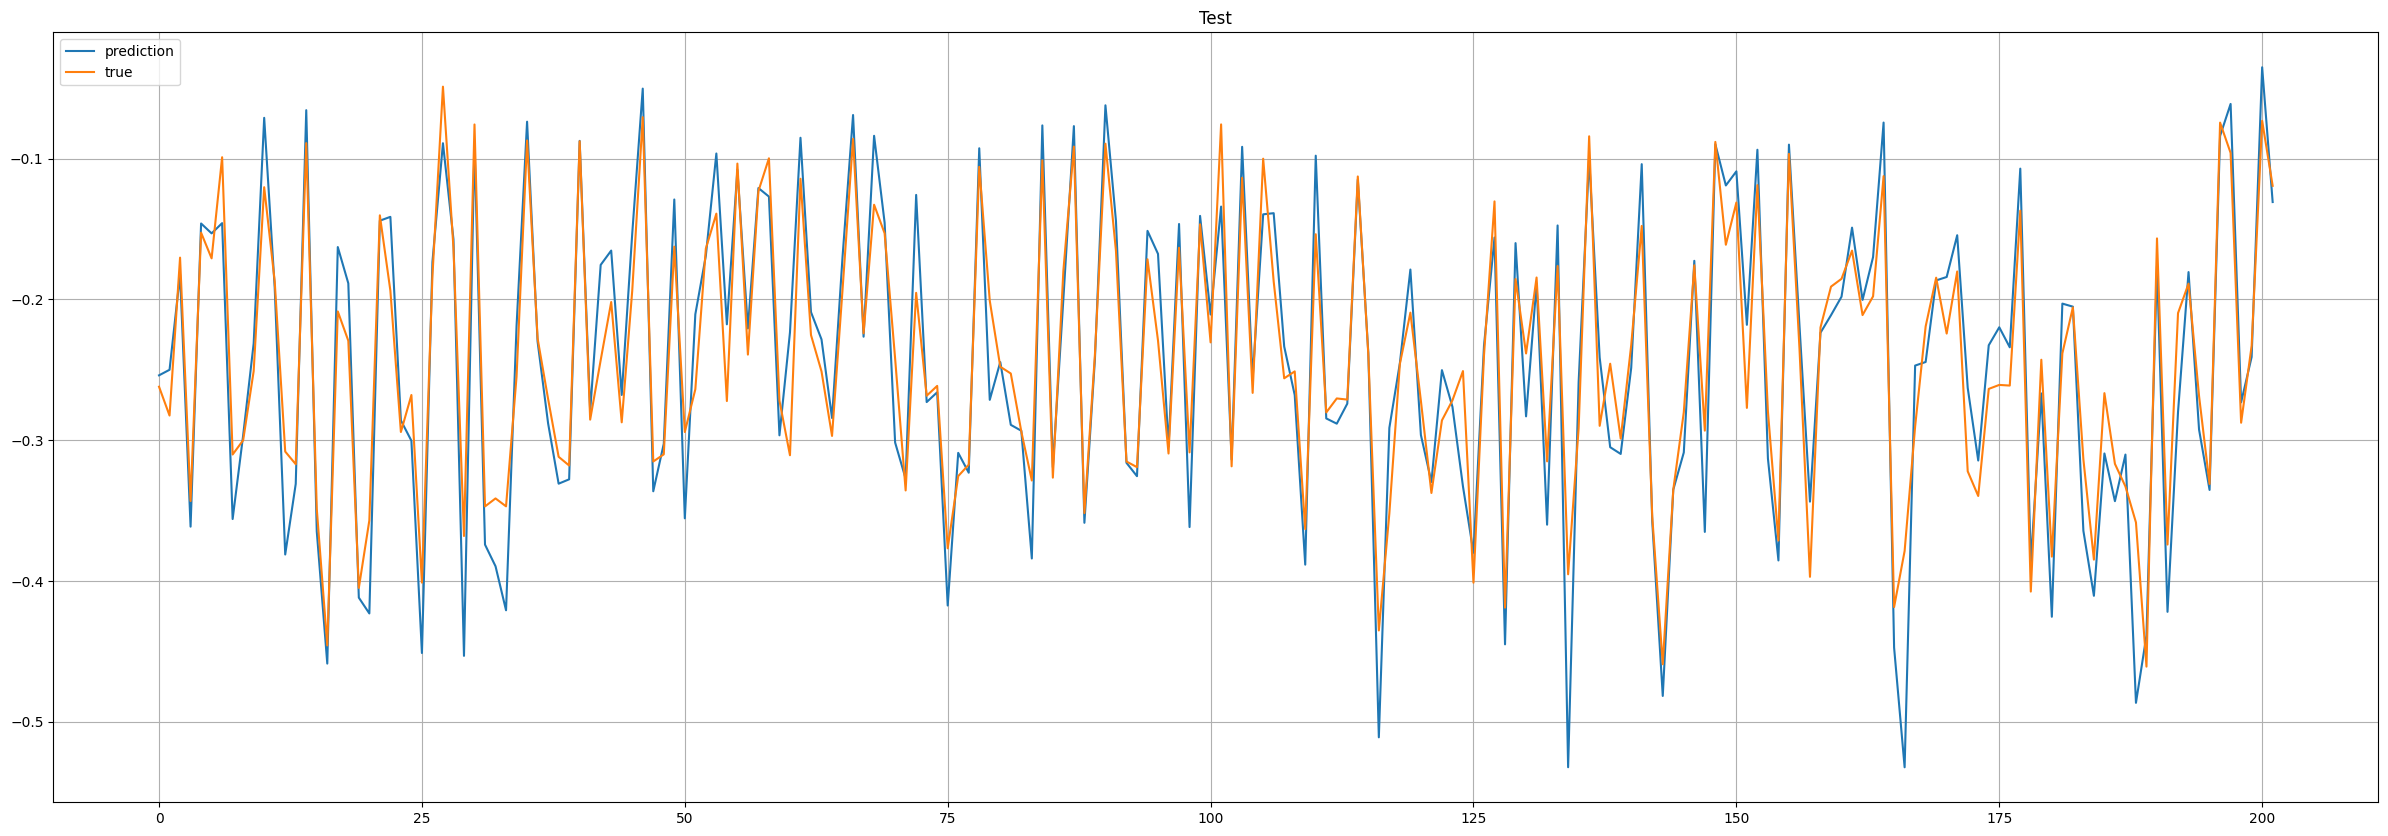

In [10]:
def plot_test(model, scale, test_dataset):
    "测试"
    x_list, y_list, predictions = [], [], []
    for xs, ys in test_dataset:
        for x, y in zip(xs, ys):
            x_list.append(x)
            y_list.append(y.asnumpy().flatten())

    for x in x_list:
        predictions.append(predict(model, scale, x))
    
    error = nn.MSE()
    mse = error(ms.tensor(predictions), ms.tensor(y_list))
    print("损失函数为：", mse)

    x = range(len(predictions))
    plt.figure(figsize=(30, 10))
    plt.plot(x, predictions, label='prediction')
    plt.plot(x, y_list, label='true')
    plt.title('Test')
    plt.legend()
    plt.grid()
    plt.show()
    return predictions, y_list

predictions, y_list = plot_test(model, scale, scale_dataset)

最后查看在测试集上的预测效果。

损失函数为： 0.009491249476328935


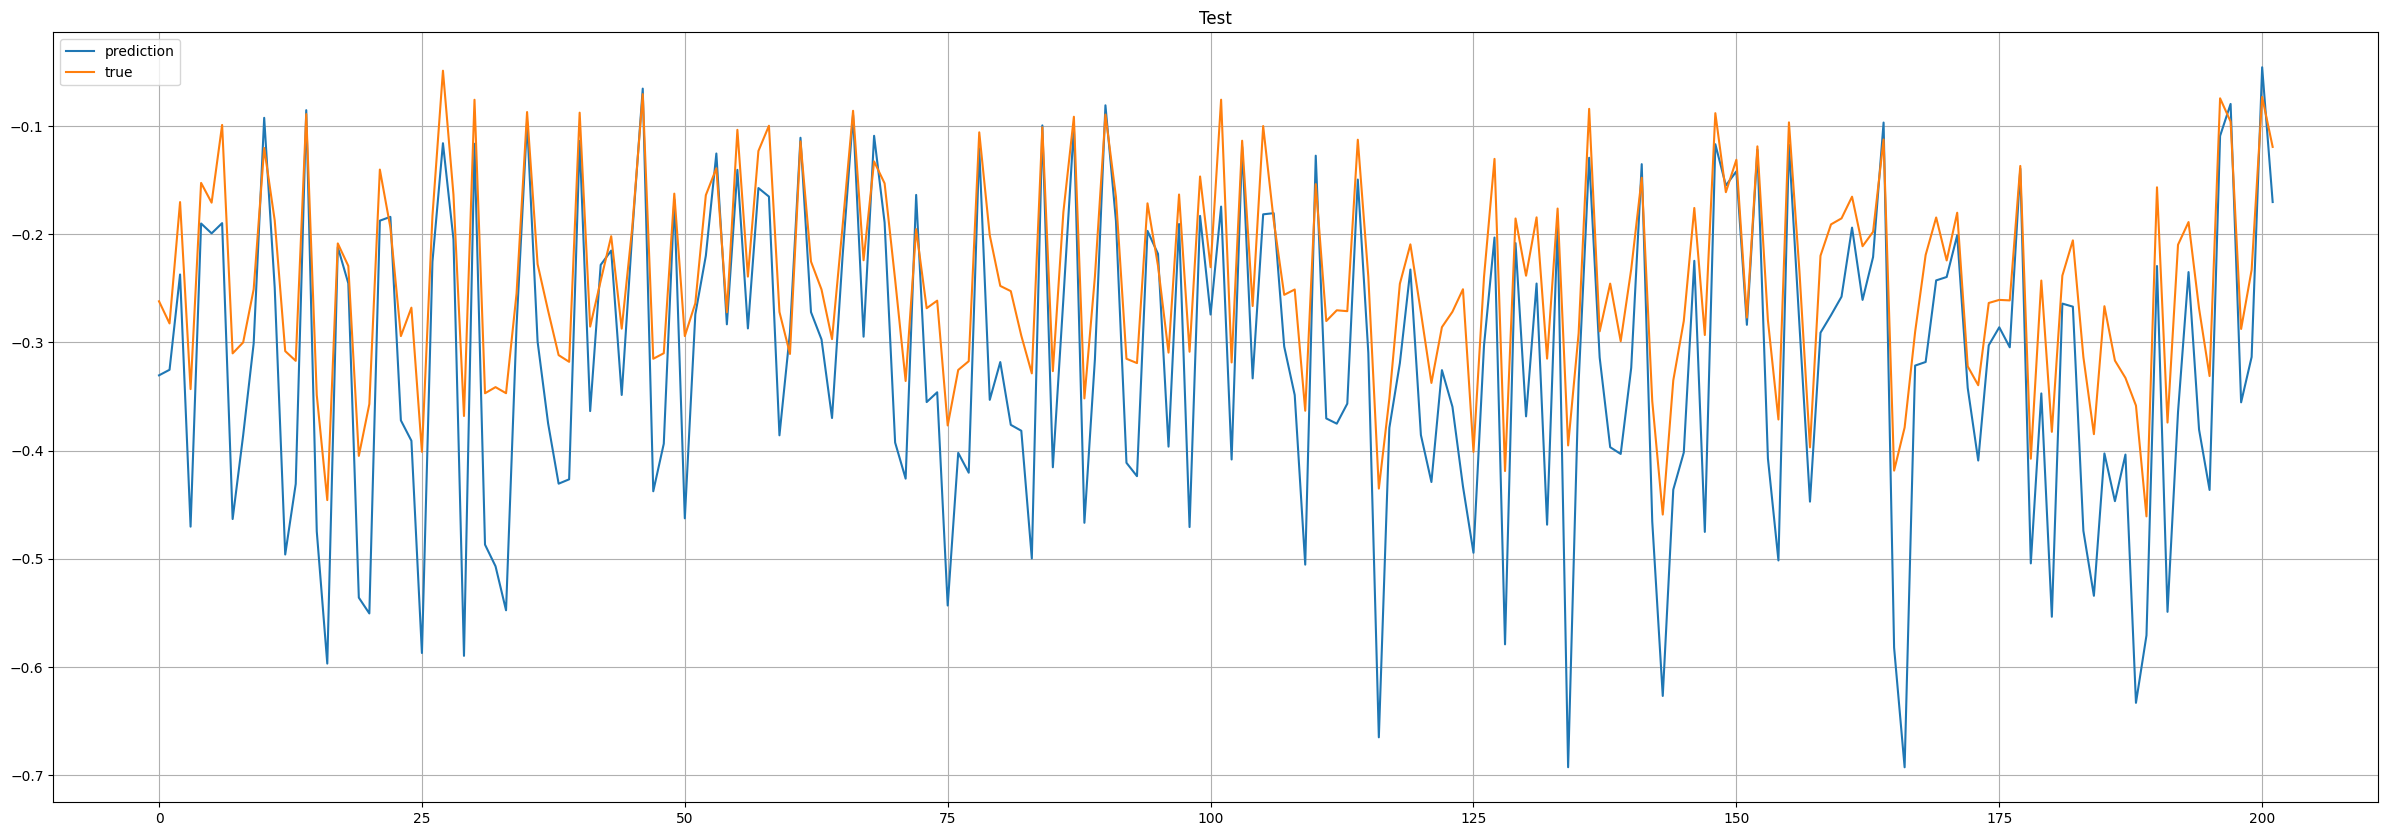

In [11]:
predictions, y_list = plot_test(model, 10, scale_dataset)

可见，训练好的模型可以很好地预测股票走势。

### 完整代码如下

[WARNING] ME(24568:18404,MainProcess):2025-05-23-15:11:27.894.554 [mindspore\context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


epoch: 1 step: 50, loss is 0.15613135695457458
epoch: 1 step: 100, loss is 0.10429250448942184
epoch: 1 step: 150, loss is 0.1573553830385208
epoch: 1 step: 200, loss is 0.14571119844913483
epoch: 1 step: 250, loss is 0.18019801378250122
缩放因子为： 7.684397934452219
损失函数为： 0.00839108613229567


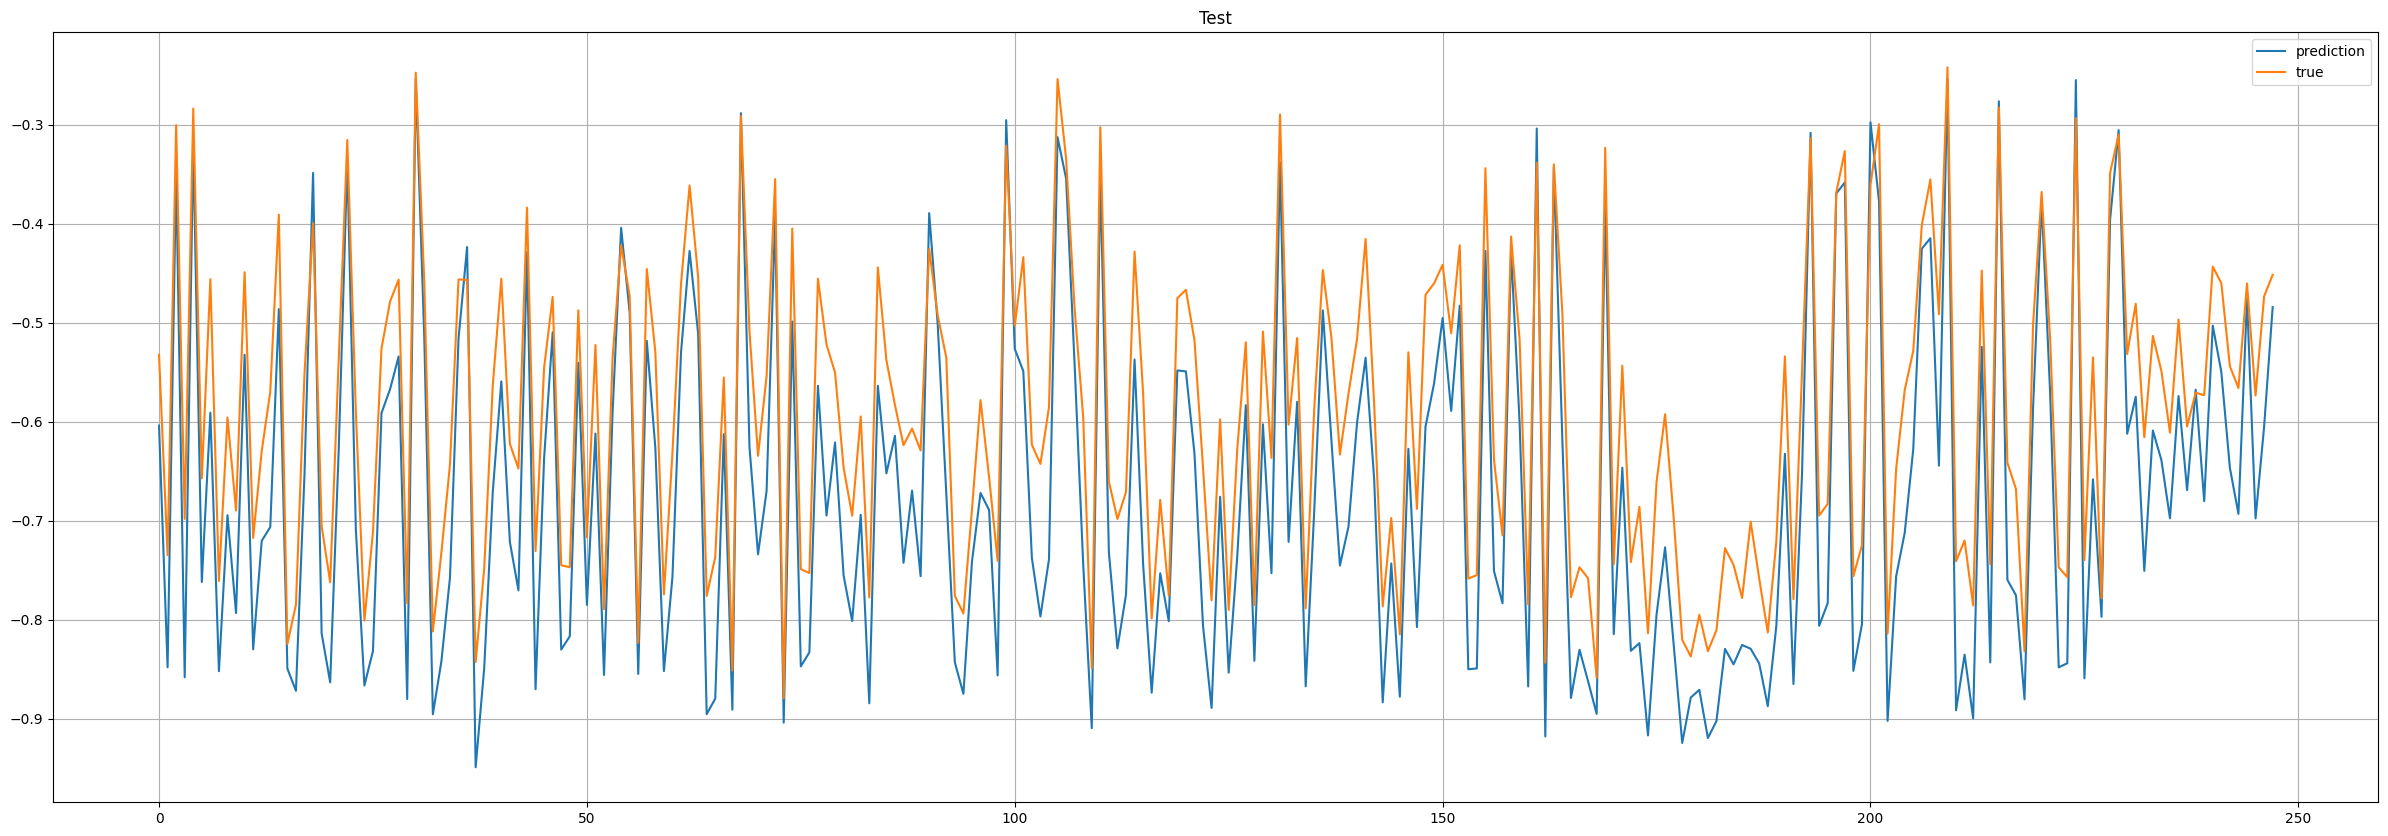

In [12]:
from mindquantum import *
import mindspore as ms
import numpy as np
from mindspore.dataset import NumpySlicesDataset
from mindspore import nn, Model
from mindspore.train.callback import LossMonitor
import matplotlib.pyplot as plt

ms.set_seed(1)                                     # 设置生成随机数的种子
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

def get_dataset(file_name:str='BA', x_length:int=5, rate:float=0.8, batch_size:int=4):
    "获取股票数据并构建数据集 除了正常的训练集和测试集之外，还将训练集中的后 20% 构造为单独的数据集，用于确定模型结果的缩放因子。"

    # 读取数值数据, 第 4 行为 Close 收盘价
    data = np.loadtxt(f'./src/{file_name}.csv', delimiter=',', skiprows=1, usecols=[4])

    # 数据缩放到 -1 到 1 之间，后续作为编码时单量子比特的旋转角度
    min_val = min(data)
    max_val = max(data)
    scaled_data = [2 * ((x - min_val) / (max_val - min_val)) - 1 for x in data]
    
    # 拆分
    x, y = [], []
    size = len(data)
    for i in range(size - x_length):
        x.append(scaled_data[i:i + x_length])
        y.append(scaled_data[i + x_length])
    
    point0 = int(0.8*rate*size) # 将训练集中的后 20% 用于确定缩放因子
    point1 = int(rate*size)
    train_dataset = NumpySlicesDataset((x[:point1], y[:point1]), column_names=["x", "y"]).batch(batch_size)
    scale_dataset = NumpySlicesDataset((x[point0:point1], y[point0:point1]), column_names=["x", "y"]).batch(8)
    test_dataset = NumpySlicesDataset((x[point1:], y[point1:]), column_names=["x", "y"]).batch(8)
    return train_dataset, scale_dataset, test_dataset


def get_pqc_circ(n_qubits:int, name:str):
    "返回 QGRU 模块中的一个 PQC 模块。"
    circ = Circuit()
    circ += BarrierGate(False).on(range(n_qubits))
    circ += UN(H, n_qubits)
    for i in range(n_qubits-1):
        circ += X.on(i+1, i)
    circ += X.on(0, i+1) # type:ignore

    if n_qubits == 2:
        circ.x(1,0)
        circ.x(0,1)
    else:
        qubits = list(range(n_qubits)) * 2
        for i in range(n_qubits):
            circ.x(qubits[i+2], qubits[i])
    circ += BarrierGate(False).on(range(n_qubits))

    theta = PRGenerator(name)
    for i in range(n_qubits):
        circ.rx(theta.new(), i)
        circ.rz(theta.new(), i)
        circ.rx(theta.new(), i)
    return circ


def get_gru_circ(qubits:list[int], encoder_name:str):
    "返回一个 QGRU 单元的量子线路"
    circ = Circuit()

    # 编码
    circ.ry(encoder_name, qubits[1])
    circ.ry(encoder_name, qubits[3])
    circ.ry(encoder_name, qubits[6])
    circ.as_encoder()
    
    circ += apply(get_pqc_circ(2, 'a'), [qubits[1], qubits[2]])
    circ += apply(get_pqc_circ(2, 'b'), [qubits[3], qubits[4]])
    circ += apply(get_pqc_circ(2, 'c'), [qubits[0], qubits[1]])
    circ += apply(get_pqc_circ(2, 'd'), [qubits[4], qubits[5]])
    circ += apply(get_pqc_circ(2, 'e'), [qubits[5], qubits[6]])
    circ += apply(get_pqc_circ(2, 'f'), [qubits[2], qubits[5]])
    circ += apply(get_pqc_circ(4, 'g'), [qubits[0], qubits[1], qubits[2], qubits[5]])
    return circ


def get_apply_qubits(x_length:int):
    "返回每次施加量子线路时所作用的量子比特, x_length 应小于 7 不然后续模拟器跑不动了。"
    qubits = []
    aux_qubits = list(range(4, 4 + 3 * x_length))
    j = 3 # aux 计数
    qubits = [[0, 4, 1, 5, 2, 3, 6]]

    for i in range(x_length - 1):
        tem = [qubits[-1][0], aux_qubits[j], qubits[-1][1], aux_qubits[j+1], qubits[-1][2], qubits[-1][5], aux_qubits[j+2]]
        qubits.append(tem)
        j += 3
    return qubits


def get_circ(x_length:int):
    "获取基于 QGRU 的 QGRNN 整体线路图"
    qubits = get_apply_qubits(x_length)

    circ = Circuit()
    for i in range(x_length):
        circ += get_gru_circ(qubits[i], f"data_{i}")
    return circ

def get_model(x_length):
    circ = get_circ(x_length)
    sim = Simulator('mqvector', circ.n_qubits)
    ham = Hamiltonian(QubitOperator('Z3'))

    sim = Simulator('mqvector', circ.n_qubits)
    grad_ops = sim.get_expectation_with_grad(ham, circ)

    circ.ansatz_params_name
    qnet = MQLayer(grad_ops)
    optimizer = nn.Adam(params=qnet.trainable_params(), learning_rate=0.1)
    model = Model(qnet, nn.MSELoss(), optimizer, metrics={"mse"})
    return model


def remove_outliers(list1, list2, threshold=0.2):
    """去除列表1中偏离中心的异常点及对应列表2的点"""
    # 转换为numpy数组以便计算
    arr1 = np.array(list1)
    arr2 = np.array(list2)
    
    # 计算列表1的中心值(中位数)和绝对偏差
    median = np.median(arr1)
    deviations = np.abs(arr1 - median)
    
    # 计算阈值(使用0.6745 * MAD作为标准差估计，对应正态分布)
    # 这里我们调整阈值以去除约20%的异常点
    threshold_value = np.percentile(deviations, 100*(1-threshold))
    
    # 创建掩码，True表示保留的点
    mask = deviations <= threshold_value
    
    # 应用掩码过滤两个数组
    filtered_arr1 = arr1[mask]
    filtered_arr2 = arr2[mask]
    return filtered_arr1.tolist(), filtered_arr2.tolist()


def find_scale_factor(model, scale_dataset):
    "模型在预测时, 结果中会有一个神秘的缩放因子存在, 本函数用于确定该因子"
    x_list = []
    predictions, y_list = [], []
    
    for xs, ys in scale_dataset:
        for x, y in zip(xs, ys):
            x_list.append(x)
            y_list.append(y.asnumpy().flatten())

    for x in x_list:
        predictions.append(model.predict(ms.tensor([x])).asnumpy().flatten())

    y_list, predictions = remove_outliers(y_list, predictions, 0.2) # 删除异常点
    scale = np.mean(y_list) / np.mean(predictions)
    return scale


def predict(model, scale, x):
    "乘上缩放因子才是最终的预测结果"
    prediction = scale * model.predict(ms.tensor([x])).asnumpy().flatten()
    return prediction


def plot_test(model, scale, test_dataset):
    "测试"
    x_list, y_list, predictions = [], [], []
    for xs, ys in test_dataset:
        for x, y in zip(xs, ys):
            x_list.append(x)
            y_list.append(y.asnumpy().flatten())

    for x in x_list:
        predictions.append(predict(model, scale, x))
    
    error = nn.MSE()
    mse = error(ms.tensor(predictions), ms.tensor(y_list))
    print("损失函数为：", mse)

    x = range(len(predictions))
    plt.figure(figsize=(30, 10))
    plt.plot(x, predictions, label='prediction')
    plt.plot(x, y_list, label='true')
    plt.title('Test')
    plt.legend()
    plt.grid()
    plt.show()
    return predictions, y_list


file_name = 'BA'
x_length = 4
rate = 0.8
batch_size = 4
epoch = 1
train_dataset, scale_dataset, test_dataset = get_dataset(file_name, x_length, rate, batch_size)
model = get_model(x_length)
model.train(epoch, train_dataset, callbacks=[LossMonitor(50)]) 
scale = find_scale_factor(model, scale_dataset) 
print('缩放因子为：', scale)
predictions, y_list = plot_test(model, scale, test_dataset)
